In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core import display as ICD
import seaborn as sns
import glob
import scipy
import os
pd.set_option('display.max_columns', 100)
from helpers import *

In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F      # activation function
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # split adata
from sklearn.preprocessing import StandardScaler      # Standardzation


In [3]:
DATA_FOLDER = './'

In [ ]:
RESULTS_FOLDER='/raid/motus/results/neuralnetwork/'

In [4]:
os.listdir(DATA_FOLDER)

['neural_network.ipynb',
 'regression_mat_year.csv',
 '__pycache__',
 'ridge_regression.ipynb',
 '.ipynb_checkpoints',
 'feature_selection_rf.ipynb',
 'helpers.py',
 'feature_selection_stepwise.ipynb']

### Regression matrix manipulation

Importing regression matrix

In [5]:
tot_df=pd.read_csv(DATA_FOLDER+'regression_mat_year.csv',index_col=0)

Transform absolute value and direction in vector components

In [6]:
tot_df=vectorize_wind_speed(tot_df)

In [7]:
tot_df.shape

(535470, 23)

Shorten the matrix for developping purposes

In [8]:
number_trial=20000
tot_df_small=tot_df.iloc[:number_trial,:]
tot_df_small.shape

(20000, 23)

## Splitting the data (trial set)

In [9]:
X_trial = np.array(tot_df_small.drop(columns=['u_x', 'u_y','u_z']))
Y_trial = np.array(tot_df_small[['u_x', 'u_y']]) # First consider 1 dimension output

In [10]:
x_tr_trial_, x_te_trial_, y_tr_trial_, y_te_trial_ = train_test_split(X_trial, Y_trial, test_size = 0.3, random_state = 0)

In [11]:
x_te_trial_hs_, y_te_trial_hs_=split_hs_test(x_te_trial_,y_te_trial_,hs=np.arange(1.5,22,4))

## Splitting the data

In [12]:
X = np.array(tot_df.drop(columns=['u_x', 'u_y','u_z']))
Y = np.array(tot_df[['u_x', 'u_y']]) # First consider 1 dimension output

In [13]:
x_tr_, x_te_, y_tr_, y_te_ = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [14]:
x_te_hs_, y_te_hs_=split_hs_test(x_te_,y_te_,hs=np.arange(1.5,22,4))

## Standardizing the training data (trial set)

In [15]:
k = StandardScaler().fit(x_tr_trial_)
x_tr_trial_ = k.transform(x_tr_trial_)

## Standardizing the training data

In [ ]:
k = StandardScaler().fit(x_tr_)
x_tr_ = k.transform(x_tr_)

## Standardizing anemometer test (trial set)

In [16]:
x_te_trial_standard_hs_=[]
for x_te_trial_h_ in x_te_trial_hs_:
    
    x_te_trial_standard_hs_.append(k.transform(x_te_trial_h_))

## Standardizing anemometer test

In [ ]:
x_te_standard_hs_=[]
for x_te_h_ in x_te_hs_:
    
    x_te_standard_hs_.append(k.transform(x_te_h_))

# Neural Network

### Build the Net

In [17]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)  
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)  
        
    def forward(self, x):
        a1 = F.relu(self.hidden1(x)) 
        a2 = F.relu(self.hidden2(a1))
        #a1 = torch.sigmoid(self.hidden(x))
        #a1 = self.hidden(x) # 隐藏层用 relu
        y = self.predict(a2)
        return y

net = Net(n_feature=x_tr_.shape[1], n_hidden=100, n_output=2)
print(net)

Net(
  (hidden1): Linear(in_features=20, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=2, bias=True)
)


Establish loss function and optimizer

In [18]:
loss_func = torch.nn.MSELoss()   
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)

Split the test dataset according to the different anemometers

Convert the vectors in tensors

In [19]:
x_te_trial_standard_hs=[]

for x_te_trial_standard_h_ in x_te_trial_standard_hs_:
    
    x_te_trial_standard_hs.append(torch.from_numpy(x_te_trial_standard_h_).type(torch.FloatTensor))

In [ ]:
x_te_standard_hs=[]

for x_te_standard_h_ in x_te_standard_hs_:
    
    x_te_standard_hs.append(torch.from_numpy(x_te_standard_h_).type(torch.FloatTensor))

In [20]:
x_tr_trial_ = torch.from_numpy(x_tr_trial_)
y_tr_trial_ = torch.from_numpy(y_tr_trial_)
x_te_trial_ = torch.from_numpy(x_te_trial_)
y_te_trial_ = torch.from_numpy(y_te_trial_)
x_tr_trial = x_tr_trial_.type(torch.FloatTensor)
y_tr_trial = y_tr_trial_.type(torch.FloatTensor)
x_te_trial = x_te_trial_.type(torch.FloatTensor)
y_te_trial = y_te_trial_.type(torch.FloatTensor)
x_tr_trial, y_tr_trial = Variable(x_tr_trial), Variable(y_tr_trial)
x_te_trial, y_te_trial = Variable(x_te_trial), Variable(y_te_trial)

x_te_trial_standard_hs_variable=[]
y_te_trial_hs_variable=[]

for x_te_trial_standard_h, y_te_trial_s_ in zip(x_te_trial_standard_hs, y_te_trial_hs_):
    
    x_te_trial_standard_hs_variable.append(Variable(x_te_trial_standard_h ))
    y_te_trial_hs_variable.append(Variable(torch.from_numpy(y_te_trial_s_).type(torch.FloatTensor)))

In [ ]:
x_tr = torch.from_numpy(x_tr_)
y_tr = torch.from_numpy(y_tr_)
x_te = torch.from_numpy(x_te_)
y_te = torch.from_numpy(y_te_)
x_tr = x_tr.type(torch.FloatTensor)
y_tr = y_tr.type(torch.FloatTensor)
x_te = x_te.type(torch.FloatTensor)
y_te = y_te.type(torch.FloatTensor)
x_tr, y_tr = Variable(x_tr), Variable(y_tr)
x_te, y_te = Variable(x_te), Variable(y_te)

x_te_standard_hs_variable=[]
y_te_hs_variable=[]

for x_te_standard_h, y_te_h_ in zip(x_te_standard_hs, y_te_hs_):
    
    x_te_standard_hs_variable.append(Variable(x_te_standard_h))
    y_te_hs_variable.append(Variable(torch.from_numpy(y_te_h_).type(torch.FloatTensor)))

### Train the Net

In [43]:
import matplotlib.pyplot as plt
epochs=500

losses=[]
for t in range(epochs):
    prediction = net(x_tr_trial)
    loss = loss_func(prediction, y_tr_trial)
    #print loss
    optimizer.zero_grad()    # clear gradients for next train
    loss.backward()          # backpropagation
    optimizer.step()         # update（w、b）
    
    if t%10==0:
        print ('The loss is',loss.detach().numpy())
        losses.append(loss.detach().numpy())

pd.Series(losses).to_csv(RESULTS_FOLDER+'loss_log')

The loss is 0.16527355
The loss is 0.16105065
The loss is 0.1614185
The loss is 0.1636217
The loss is 0.16551872
The loss is 0.17653975
The loss is 0.18801731
The loss is 0.16680898
The loss is 0.15756479
The loss is 0.16109277
The loss is 0.16532649
The loss is 0.16872564
The loss is 0.1804869
The loss is 0.1718501
The loss is 0.1661315
The loss is 0.16343027
The loss is 0.1616803
The loss is 0.16043055
The loss is 0.16178887
The loss is 0.16681872
The loss is 0.16865179
The loss is 0.1748861
The loss is 0.16753212
The loss is 0.16057296
The loss is 0.15796189
The loss is 0.1571813
The loss is 0.15767987
The loss is 0.16085161
The loss is 0.16447023
The loss is 0.16052853
The loss is 0.1571367
The loss is 0.15327325
The loss is 0.15341815
The loss is 0.15780345
The loss is 0.16465482
The loss is 0.17238213
The loss is 0.16555747
The loss is 0.15271801
The loss is 0.14858074
The loss is 0.14964357
The loss is 0.15253466
The loss is 0.15381528
The loss is 0.15128224
The loss is 0.155916

### Predict

In [41]:
y_preds=[]
for x_te_trial_standard_h_variable in x_te_trial_standard_hs_variable:
    net.eval()
    predict = net(x_te_trial_standard_h_variable)
    y_pred = predict.data.numpy()
    y_preds.append(y_pred)

In [ ]:
path='/raid/motus/results/neuralnetwork/'

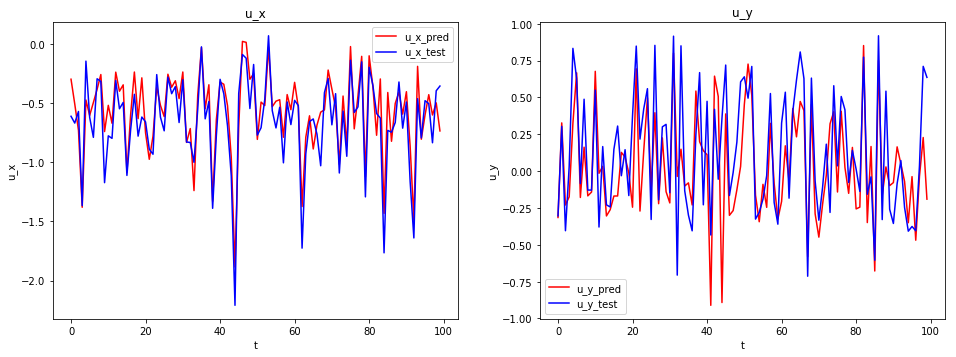

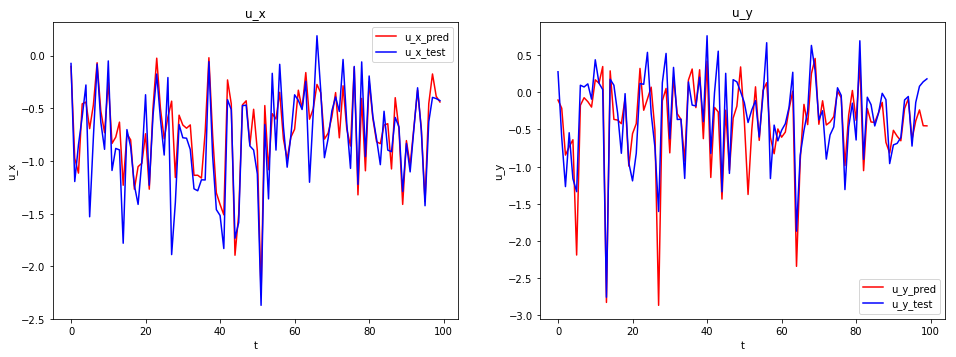

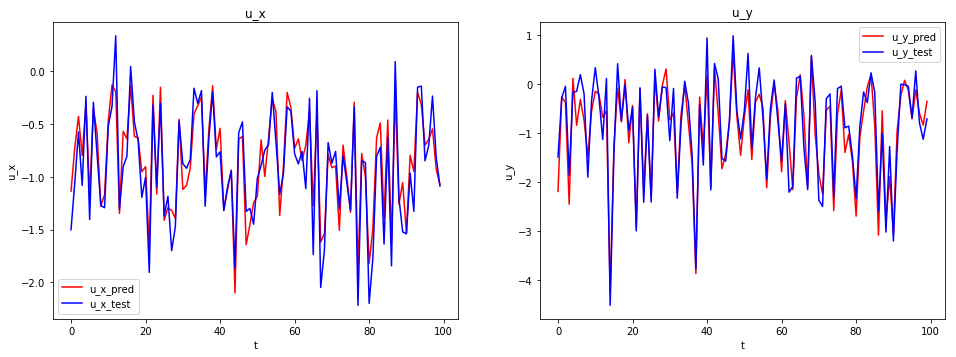

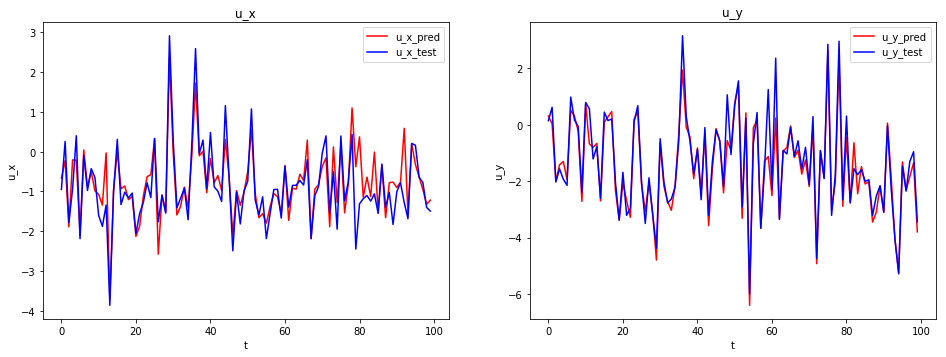

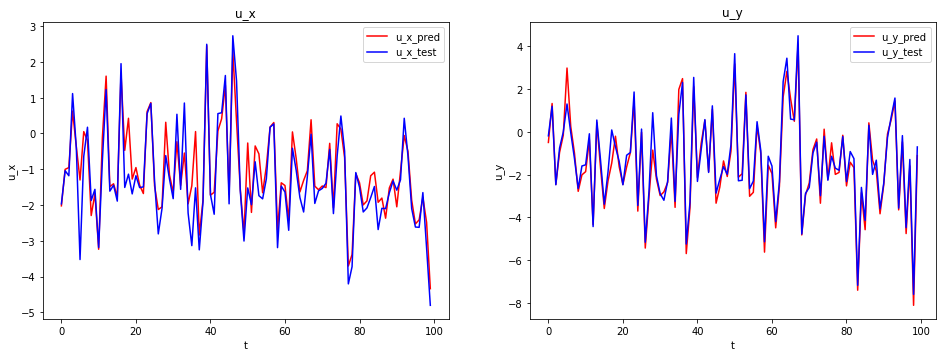

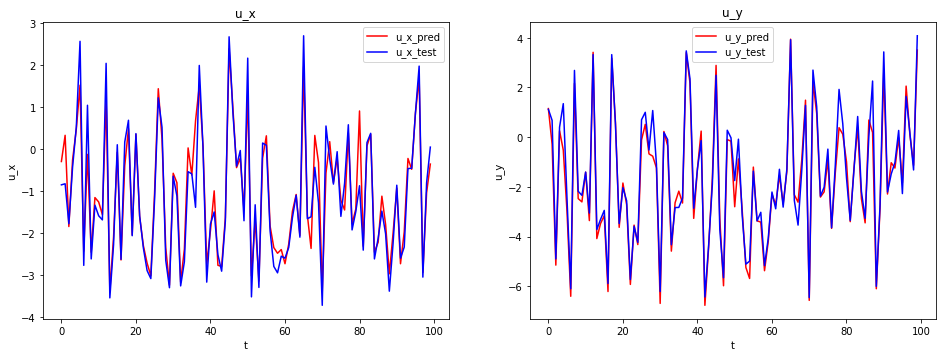

In [42]:
plot_ys(y_preds,y_te_trial_hs_,_,save=False,interval=[100,200],name='graph')

In [33]:
for i, (y_pred, y_te_trial_h_) in enumerate(zip(y_preds, y_te_trial_hs_)):
    
    print ('MSE anemometer'+' ', i , 'is', np.mean(np.square(y_pred-y_te_trial_h_)))

MSE anemometer  0 is 0.08430110149261243
MSE anemometer  1 is 0.11264255747121105
MSE anemometer  2 is 0.1679503641534534
MSE anemometer  3 is 0.3715813176124328
MSE anemometer  4 is 0.3882558674989106
MSE anemometer  5 is 0.6475779992024456
